## Analyse af forskellige depoter ved forskellige depotstørrelser og tidshorisont
08/12/2020

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/jovyan/work/dkfinance_modeller'))
if module_path not in sys.path:
    sys.path.append(module_path)
import os
from typing import List, Tuple
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
import seaborn as sns
import pdb
from copy import deepcopy

import dkfinance_modeller.aktieskat.depotmodel as depotmodel
import dkfinance_modeller.aktieskat.kurtage as kurtage
import dkfinance_modeller.aktieskat.skat as skat
import dkfinance_modeller.aktieskat.vaerdipapirer as værdipapirer
import dkfinance_modeller.aktieskat.valuta as valuta
import dkfinance_modeller.utility.formler as formler

Opsætning af depoter

In [2]:
def depoter(kapital: float, optimering: float, tlh: float = 0, diy_only: bool = False) -> Tuple[depotmodel.DepotModel, depotmodel.DepotModel]:
    """Definerer depoter.

    Returns:
      Depot med realationsbeskatning
      udb_var: [udbytte efter leak, udb_md, udb_år, ekstra udb andel, skatte optimering]
    """
    etf =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0, 0] 
    imb =     værdipapirer.ETF(kurs=100, åop=0.55 / 100, beskatningstype="realisation"), [0.85, 0, 1, 0.3, optimering, 0]
    diy =     værdipapirer.ETF(kurs=100, åop=0.3 / 100,  beskatningstype="realisation"), [1.00, 1, 0, 0, optimering, tlh]
    pension = værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0, 0] 
    ask =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0, 0 ] 
    mix1 =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0, 0] 
    mix2 =     værdipapirer.ETF(kurs=100, åop=0.55 / 100, beskatningstype="realisation"), [0.85, 0, 1, 0.3, 0, 0]
    skat_fri = skat.Skat("aktie")
    skat_fri.progressionsgrænse = 110600
    skat_pension = skat.Skat("pension")
    skat_ask = skat.Skat("ask")
    etf = ['etf', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[etf[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [etf[1]]]
    imb = ['imb', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="Dkk"),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[imb[0]],
        ETF_fordeling=[1.0],
    ), [imb[1]]]
    diy = ['diy'+str(tlh), depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=partial(kurtage.saxo_nordnet_kurtage,
                valutakurs=7.44,
                kurtageprocent=0.003, #grundet køb af små positioner
                minimums_kurtage=2 * 7.44,
                valutakurtage=0.0,
                saxo_usd_type=False),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[diy[0]],
        ETF_fordeling=[1.0],
    ), [diy[1]]]
    pension = ['pension', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_pension,
        minimumskøb=5000,
        ETFer=[pension[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.nordnet_valutakonto_kurtage,
    ), [pension[1]]]
    ask = ['ask', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=False),
        skatteklasse=skat_ask,
        minimumskøb=5000,
        ETFer=[ask[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [ask[1]]]
    mix = ['mix', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[mix1[0], mix2[0]],
        ETF_fordeling=[0.1,0.9],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [mix1[1], mix2[1]]]
    if diy_only:
        return [diy] #depoter, udbytte parametre
    else:
        return [etf, imb, mix, diy, pension, ask] #depoter, udbytte parametre


Diverse detailjer om depotet

In [3]:
def output(dep):
    print('Totalværdi: ' , dep.total_salgsværdi(medregn_fradrag=True) , '\n', 
    'Ubeskattet: ' , dep.ubeskattet,  '\n', 
    'Kapital: ' , dep._kapital,  '\n', 
    'Antal Værdipapirer: ' , dep.ETFer[0].antal_værdipapirer,  '\n', 
    'Kursværdi: ' , dep.ETFer[0].antal_værdipapirer * dep.ETFer[0].kurs, '\n', 
    'kurs: ',  dep.ETFer[0].kurs,  '\n', 
    'beskattet kurs: ' , dep.ETFer[0].beskattet_kurs,  '\n', 
    'Måned: ' , dep.måned, '\n',
    'lagerrealisering: ', dep.ETFer[0].lagerrealisering(ændre_kurs=False)
    )    

## Skatteoptimering
For X år før slutdato påbegyndes skatteoptimering ved at realisere op til progressionsgrænsen i sidste måned af året, dog kun hvis urealiseret gevinst udgør mindst 50% af depotværdien
Når X+1 medfører lavere slutresultat stoppes kørslen og X registreres som det optimale år at påbegynde aktiv skatteoptimering.

Modellen genneføres for forskellige depotværdier og andel af urealiseret afkast samt årligt afkast.

In [4]:
def realisering(value: 'float', urealiseret : 'float', afkast_list : 'list'):
    """

    """
    imb = depoter(value / (1 + urealiseret / 100), optimering=0)[1][1]
    imb.ETFer[0].kurs = 100 * (1 + urealiseret / 100)
    imb_real = deepcopy(imb)
    for n, afk_perc in enumerate(afkast_list):
        imb.afkast_månedlig([afk_perc * imb.ETFer[0].kurs], [0.0])
        afkast = afk_perc * imb_real.ETFer[0].kurs
        if imb_real.måned == 11 and n < len(afkast_list):
            #urealiseret = imb_real.ubeskattet + sum([x.lagerrealisering(ændre_kurs=False) for x in imb_real.ETFer])
            urealiseret = sum([x.lagerrealisering(ændre_kurs=False) for x in imb_real.ETFer])
            realiser = max(0, min(urealiseret, imb_real.skatteklasse.progressionsgrænse))
            realiser_ratio = realiser / urealiseret
            if realiser_ratio < 0.5:
                salg = depotmodel.køb_værdipapirer(realiser_ratio * imb_real.ETFer[0].antal_værdipapirer * imb_real.ETFer[0].kurs, imb_real.ETFer[0].kurs, imb_real.kurtagefunktion)
                imb_real.ETFer[0].antal_værdipapirer -= salg[2]
                imb_real.ubeskattet -= salg[1]
                imb_real.afkast_månedlig([afkast],[(-salg[0]-2*salg[1])/(imb_real.ETFer[0].antal_værdipapirer)])
            else: 
                imb_real.afkast_månedlig([afkast],[0.0])
            imb.skatteklasse.progressionsgrænse *= 1.02
            imb_real.skatteklasse.progressionsgrænse *= 1.02
        else:
            imb_real.afkast_månedlig([afkast],[0.0])
    return imb, imb_real


Beregn optimal start for realisering: Punktet hvor længere horisont reducerer merafkastet ved det realiserede depot

In [5]:
def cutoff(value, unrealized, return_yearly, full_out = False):
    fordel = 0
    i =23
    total = []
    while fordel > -1 and i < 360:    
        imb, imb_real = realisering(value, unrealized, [(1 + return_yearly)**(1/12)-1]*i)
        ratio = (imb_real.total_salgsværdi(medregn_fradrag=True)-imb.total_salgsværdi(medregn_fradrag=True))/imb.total_salgsværdi(medregn_fradrag=True)
        if full_out:
            total.append([(i+1)/12, imb.total_salgsværdi(medregn_fradrag=True),ratio])
        else:
            total= [(i+1)/12, imb.total_salgsværdi(medregn_fradrag=True),ratio]
        if fordel < ratio:
            fordel = ratio
        else:
            fordel = -1
        i += 12
        #output(imb)
        #output(imb_real)
    return total

In [6]:
cutoff(55300 *5, 500, 0.09, full_out= True)

[[2.0, 222834.94358115323, 0.02601461926982241],
 [3.0, 238851.35955286043, 0.01556587222164942]]

In [7]:
result = []
pg = 55300
for value in [x * 50000 for x in range(1,30)]:
    for unrealized in range (100,2001,100):
        for return_yearly in np.linspace(0.04, 0.14, 11).round(2):
            result.append([value, unrealized, return_yearly, cutoff(value, unrealized, return_yearly)[0]-1])

result_df = pd.DataFrame(result)
headers = ['value', 'unrealized','return_yearly',  'cutoff']
#dtypes = {'kapcost_basis': 'int', 'unrealized': 'int','return_yearly': 'float', 'cutoff': 'int'}
result_df.columns = headers
#result_df = result_df.astype(dtype=dtypes)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


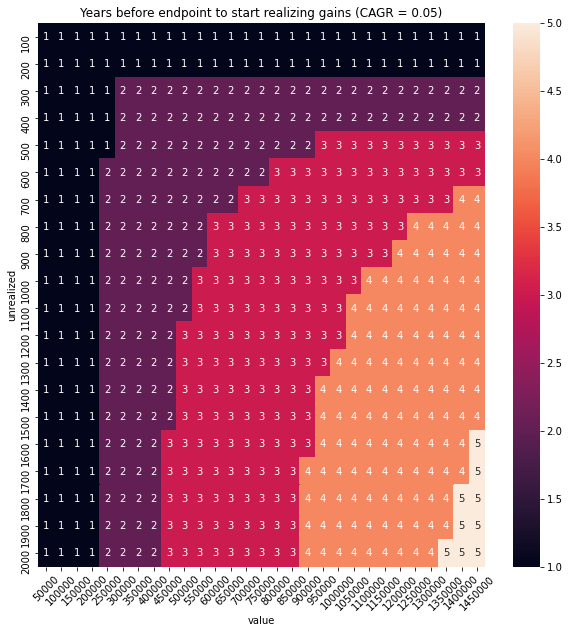

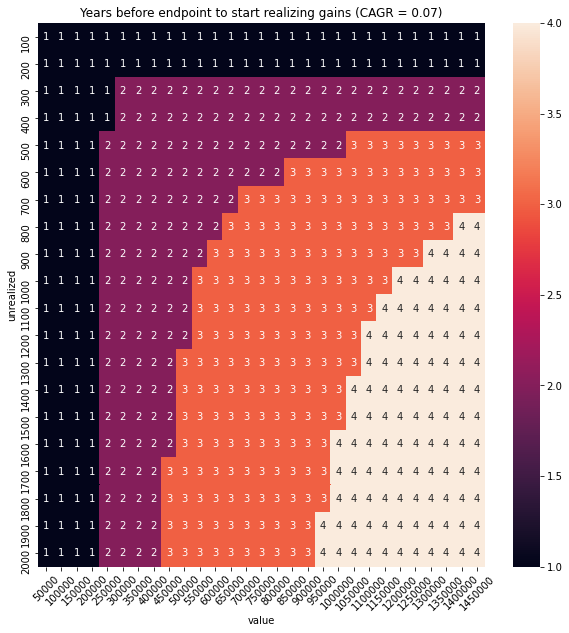

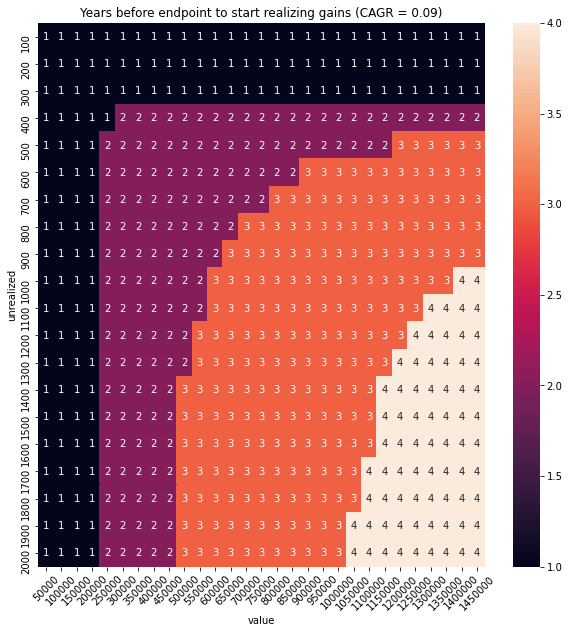

In [8]:
for ret in [0.05, 0.07, 0.09]:
    result_pivot = result_df[result_df.return_yearly == ret].pivot(index='unrealized', columns='value', values='cutoff')
    fig, ax = plt.subplots(figsize=(10, 10))
    sns_plt = sns.heatmap(
        result_pivot,
        annot = True
    ).set_title('Years before endpoint to start realizing gains (CAGR = '+str(ret) + ')' )
    plt.xticks(rotation=45)
    ax.locator_params(nbins=20, axis='y')
    plt.show()